In [1]:
# Install required packages if not already installed
required_packages <- c("httr", "jsonlite", "dplyr", "ggplot2", "readr", 
                      "Seurat", "patchwork", "viridis", "RColorBrewer", 
                      "gridExtra", "knitr", "DT")

for (pkg in required_packages) {
  if (!require(pkg, character.only = TRUE)) {
    install.packages(pkg)
    library(pkg, character.only = TRUE)
  }
}

# Set plot theme
theme_set(theme_minimal() + theme(plot.title = element_text(hjust = 0.5)))

Loading required package: httr

Loading required package: jsonlite

Loading required package: dplyr


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: ggplot2

Loading required package: readr

Loading required package: Seurat

Loading required package: SeuratObject

Loading required package: sp


Attaching package: ‘SeuratObject’


The following objects are masked from ‘package:base’:

    intersect, t


Loading required package: patchwork

Loading required package: viridis

Loading required package: viridisLite

Loading required package: RColorBrewer

Loading required package: gridExtra


Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine


Loading required package: knitr

Loading required package: DT


Attaching package: ‘DT’


The following object is masked from

## Part 1: Metadata Retrieval and Analysis from PanKbase API

### A. Query Analysis Set and Extract Linked Measurement Sets


In [2]:
# Base URLs
base_url <- "https://api.data.pankbase.org"
analysis_set_id <- "PKBDS0470WCHR"
analysis_url <- paste0(base_url, "/analysis-sets/", analysis_set_id, "/")

# Function to safely query API
safe_api_query <- function(url) {
  tryCatch({
    response <- GET(url)
    if (status_code(response) == 200) {
      return(fromJSON(content(response, "text", encoding = "UTF-8")))
    } else {
      warning(paste("API request failed for:", url, "Status:", status_code(response)))
      return(NULL)
    }
  }, error = function(e) {
    warning(paste("Error querying:", url, "-", e$message))
    return(NULL)
  })
}

# Query the analysis set
cat("Querying analysis set:", analysis_url, "\n")
analysis_data <- safe_api_query(analysis_url)

if (!is.null(analysis_data)) {
  cat("Successfully retrieved analysis set data\n")
  cat("Description:", analysis_data$description, "\n")
} else {
  stop("Failed to retrieve analysis set data")
}

Querying analysis set: https://api.data.pankbase.org/analysis-sets/PKBDS0470WCHR/ 
Successfully retrieved analysis set data
Description: Reference map of islet cell type-specific chromatin accessibility from 97,659 cells derived from single cell ATAC-seq assays of 41 non-diabetic;T1D autoantibody positive (Aab+);T1D;and T2D donors from the Human Pancreas Analysis Program 


### B. Extract Measurement Set Accessions and Query Associated Data

In [3]:
# Function to extract donor accession from sample data
extract_donor_accession <- function(sample_data) {
  if (!is.null(sample_data$donors) && length(sample_data$donors) > 0) {
    # Extract accession from donor URL
    donor_url <- sample_data$donors[[1]]
    if (is.character(donor_url)) {
      return(basename(donor_url))
    } else if (is.list(donor_url) && "accession" %in% names(donor_url)) {
      return(donor_url$accession)
    }
  }
  return(NA)
}

# Function to safely extract values with default
safe_extract <- function(data, field, default = NA) {
  if (field %in% names(data) && !is.null(data[[field]])) {
    return(data[[field]])
  }
  return(default)
}

# Function to extract sample accessions properly
extract_sample_accessions <- function(samples_data) {
  sample_accessions <- c()
  
  if (is.list(samples_data)) {
    for (sample in samples_data) {
      if (is.list(sample)) {
        # Look for accession field
        if ("accession" %in% names(sample)) {
          accession <- sample$accession
          if (is.character(accession) && length(accession) == 1) {
            # Check if it looks like a valid sample accession (starts with PKBSM)
            if (grepl("^PKBSM", accession)) {
              sample_accessions <- c(sample_accessions, accession)
            }
          }
        }
      } else if (is.character(sample)) {
        # If it's a URL string, extract the accession
        accession <- basename(sample)
        if (grepl("^PKBSM", accession)) {
          sample_accessions <- c(sample_accessions, accession)
        }
      }
    }
  }
  
  return(unique(sample_accessions))
}

# Function to extract measurement set accession from URL or path
extract_accession_from_path <- function(path_or_url) {
  if (is.character(path_or_url)) {
    # Handle both URLs and paths
    path_or_url <- gsub(".*measurement-sets/", "", path_or_url)
    path_or_url <- gsub("/.*", "", path_or_url)
    path_or_url <- gsub("/$", "", path_or_url)
    
    if (grepl("^PKBDS", path_or_url)) {
      return(path_or_url)
    }
  }
  return(NA)
}

In [4]:
cat("=== Extracting measurement sets associated with analysis set ===\n")

# Let's examine the analysis_data structure more carefully
cat("Looking for measurement sets in analysis_data...\n")

# Debug: Show the structure around input_file_sets
if ("input_file_sets" %in% names(analysis_data)) {
  cat("Found input_file_sets field\n")
  cat("Structure:\n")
  str(analysis_data$input_file_sets, max.level = 3)
}

measurement_set_accessions <- c()

# The input_file_sets should contain the measurement sets used in this analysis
# Based on your original JSON, it should be a list of objects with accession and @id fields

if ("input_file_sets" %in% names(analysis_data) && is.list(analysis_data$input_file_sets)) {
  
  for (i in seq_along(analysis_data$input_file_sets)) {
    file_set <- analysis_data$input_file_sets[[i]]
    
    cat("Processing input file set", i, "\n")
    
    if (is.list(file_set)) {
      cat("  Type: list with names:", paste(names(file_set), collapse = ", "), "\n")
      
      # Method 1: Direct accession field
      if ("accession" %in% names(file_set)) {
        accession <- file_set$accession
        cat("  Found accession:", accession, "\n")
        if (is.character(accession) && grepl("^PKBDS", accession)) {
          measurement_set_accessions <- c(measurement_set_accessions, accession)
        }
      }
      
      # Method 2: Extract from @id field
      if ("@id" %in% names(file_set)) {
        id_path <- file_set$`@id`
        cat("  Found @id:", id_path, "\n")
        
        if (is.character(id_path) && grepl("/measurement-sets/", id_path)) {
          # Extract accession from path like "/measurement-sets/PKBDS3336ZLVW/"
          accession <- gsub(".*/measurement-sets/([^/]+)/?.*", "\\1", id_path)
          cat("  Extracted accession from @id:", accession, "\n")
          
          if (grepl("^PKBDS", accession)) {
            measurement_set_accessions <- c(measurement_set_accessions, accession)
          }
        }
      }
      
      # Method 3: Check if the object itself represents a measurement set
      if ("file_set_type" %in% names(file_set) && file_set$file_set_type == "experimental data") {
        cat("  This is experimental data (likely a measurement set)\n")
      }
      
    } else if (is.character(file_set)) {
      cat("  Type: character -", file_set, "\n")
      # If it's a URL or path, try to extract accession
      if (grepl("/measurement-sets/", file_set)) {
        accession <- gsub(".*/measurement-sets/([^/]+)/?.*", "\\1", file_set)
        if (grepl("^PKBDS", accession)) {
          measurement_set_accessions <- c(measurement_set_accessions, accession)
        }
      } else if (grepl("^PKBDS", file_set)) {
        # It might be a direct accession
        measurement_set_accessions <- c(measurement_set_accessions, file_set)
      }
    }
  }
}

# Remove duplicates
measurement_set_accessions <- unique(measurement_set_accessions)

cat("\nExtracted", length(measurement_set_accessions), "measurement set accessions\n")

# If we still don't have accessions, let's try a different approach
if (length(measurement_set_accessions) == 0) {
  cat("No accessions found in input_file_sets. Trying alternative fields...\n")
  
  # Check for other possible fields
  possible_fields <- c("files", "datasets", "measurement_sets", "related_datasets")
  
  for (field in possible_fields) {
    if (field %in% names(analysis_data)) {
      cat("Checking field:", field, "\n")
      field_data <- analysis_data[[field]]
      
      if (is.list(field_data)) {
        for (item in field_data) {
          if (is.list(item) && "accession" %in% names(item)) {
            accession <- item$accession
            if (grepl("^PKBDS", accession)) {
              measurement_set_accessions <- c(measurement_set_accessions, accession)
              cat("Found accession in", field, ":", accession, "\n")
            }
          }
        }
      }
    }
  }
}

# Final attempt: Query the analysis set with more detail
if (length(measurement_set_accessions) == 0) {
  cat("Still no accessions. Querying analysis set with expand parameters...\n")
  
  # Try different query parameters that might expand the response
  expand_url <- paste0(analysis_url, "?format=json&frame=object")
  expanded_data <- safe_api_query(expand_url)
  
  if (!is.null(expanded_data)) {
    cat("Got expanded data, checking for measurement sets...\n")
    
    # Look through all fields for measurement set references
    for (field_name in names(expanded_data)) {
      field_value <- expanded_data[[field_name]]
      
      if (is.list(field_value)) {
        for (item in field_value) {
          if (is.list(item)) {
            # Check for accession
            if ("accession" %in% names(item) && grepl("^PKBDS", item$accession)) {
              measurement_set_accessions <- c(measurement_set_accessions, item$accession)
              cat("Found in expanded data:", item$accession, "\n")
            }
            
            # Check for URLs pointing to measurement sets
            for (subfield in names(item)) {
              subvalue <- item[[subfield]]
              if (is.character(subvalue) && grepl("/measurement-sets/PKBDS", subvalue)) {
                accession <- gsub(".*/measurement-sets/([^/]+)/?.*", "\\1", subvalue)
                measurement_set_accessions <- c(measurement_set_accessions, accession)
                cat("Found URL reference:", accession, "\n")
              }
            }
          }
        }
      }
    }
  }
}

measurement_set_accessions <- unique(measurement_set_accessions)

cat("\n=== Final extraction results ===\n")
cat("Found", length(measurement_set_accessions), "measurement set accessions\n")

if (length(measurement_set_accessions) > 0) {
  cat("Accessions:\n")
  for (i in seq_along(measurement_set_accessions)) {
    cat("  ", i, ":", measurement_set_accessions[i], "\n")
  }
} else {
  cat("ERROR: Could not extract any measurement set accessions\n")
  cat("Let's examine the raw input_file_sets structure:\n")
  print(analysis_data$input_file_sets)
  stop("Cannot proceed without measurement set accessions")
}

=== Extracting measurement sets associated with analysis set ===
Looking for measurement sets in analysis_data...
Found input_file_sets field
Structure:
'data.frame':	41 obs. of  4 variables:
 $ aliases      :List of 41
  ..$ : chr "klaus-kaestner:scATAC_isletCells_HPAP-035"
  ..$ : chr "klaus-kaestner:scATAC_isletCells_HPAP-036"
  ..$ : chr "klaus-kaestner:scATAC_isletCells_HPAP-039"
  ..$ : chr "klaus-kaestner:scATAC_isletCells_HPAP-040"
  ..$ : chr "klaus-kaestner:scATAC_isletCells_HPAP-044"
  ..$ : chr "klaus-kaestner:scATAC_isletCells_HPAP-045"
  ..$ : chr "klaus-kaestner:scATAC_isletCells_HPAP-047"
  ..$ : chr "klaus-kaestner:scATAC_isletCells_HPAP-049"
  ..$ : chr "klaus-kaestner:scATAC_isletCells_HPAP-050"
  ..$ : chr "klaus-kaestner:scATAC_isletCells_HPAP-051"
  ..$ : chr "klaus-kaestner:scATAC_isletCells_HPAP-052"
  ..$ : chr "klaus-kaestner:scATAC_isletCells_HPAP-053"
  ..$ : chr "klaus-kaestner:scATAC_isletCells_HPAP-054"
  ..$ : chr "klaus-kaestner:scATAC_isletCells_HPAP-0

Warning message in if (grepl("/measurement-sets/", file_set)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (grepl("^PKBDS", file_set)) {:
“the condition has length > 1 and only the first element will be used”


Processing input file set 3 
  Type: character - experimental data experimental data experimental data experimental data experimental data experimental data experimental data experimental data experimental data experimental data experimental data experimental data experimental data experimental data experimental data experimental data experimental data experimental data experimental data experimental data experimental data experimental data experimental data experimental data experimental data experimental data experimental data experimental data experimental data experimental data experimental data experimental data experimental data experimental data experimental data experimental data experimental data experimental data experimental data experimental data experimental data 


Warning message in if (grepl("/measurement-sets/", file_set)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (grepl("^PKBDS", file_set)) {:
“the condition has length > 1 and only the first element will be used”


Processing input file set 4 
  Type: character - /measurement-sets/PKBDS3336ZLVW/ /measurement-sets/PKBDS7898TJLN/ /measurement-sets/PKBDS5146ZLDB/ /measurement-sets/PKBDS9055IOIU/ /measurement-sets/PKBDS6113LMCM/ /measurement-sets/PKBDS9578WIVD/ /measurement-sets/PKBDS8408ZFOM/ /measurement-sets/PKBDS3693QGGM/ /measurement-sets/PKBDS8479AWFI/ /measurement-sets/PKBDS9700QSKT/ /measurement-sets/PKBDS4200VYZL/ /measurement-sets/PKBDS9421KTVU/ /measurement-sets/PKBDS0001LZFE/ /measurement-sets/PKBDS4712MFGY/ /measurement-sets/PKBDS5109ZNDX/ /measurement-sets/PKBDS0335TNYM/ /measurement-sets/PKBDS3953OCBC/ /measurement-sets/PKBDS1909ZJCX/ /measurement-sets/PKBDS9086HQOZ/ /measurement-sets/PKBDS9137KQFJ/ /measurement-sets/PKBDS5167CEXF/ /measurement-sets/PKBDS4630WXJM/ /measurement-sets/PKBDS6643CFEW/ /measurement-sets/PKBDS4823EHZA/ /measurement-sets/PKBDS8302SSFH/ /measurement-sets/PKBDS2697HWHF/ /measurement-sets/PKBDS2177FZNN/ /measurement-sets/PKBDS2494JCLE/ /measurement-sets/PKBDS0497

Warning message in if (grepl("/measurement-sets/", file_set)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (grepl("^PKBDS", accession)) {:
“the condition has length > 1 and only the first element will be used”



Extracted 41 measurement set accessions

=== Final extraction results ===
Found 41 measurement set accessions
Accessions:
   1 : PKBDS3336ZLVW 
   2 : PKBDS7898TJLN 
   3 : PKBDS5146ZLDB 
   4 : PKBDS9055IOIU 
   5 : PKBDS6113LMCM 
   6 : PKBDS9578WIVD 
   7 : PKBDS8408ZFOM 
   8 : PKBDS3693QGGM 
   9 : PKBDS8479AWFI 
   10 : PKBDS9700QSKT 
   11 : PKBDS4200VYZL 
   12 : PKBDS9421KTVU 
   13 : PKBDS0001LZFE 
   14 : PKBDS4712MFGY 
   15 : PKBDS5109ZNDX 
   16 : PKBDS0335TNYM 
   17 : PKBDS3953OCBC 
   18 : PKBDS1909ZJCX 
   19 : PKBDS9086HQOZ 
   20 : PKBDS9137KQFJ 
   21 : PKBDS5167CEXF 
   22 : PKBDS4630WXJM 
   23 : PKBDS6643CFEW 
   24 : PKBDS4823EHZA 
   25 : PKBDS8302SSFH 
   26 : PKBDS2697HWHF 
   27 : PKBDS2177FZNN 
   28 : PKBDS2494JCLE 
   29 : PKBDS0497QZMU 
   30 : PKBDS9996ZNSN 
   31 : PKBDS7868YWYV 
   32 : PKBDS5649TOAV 
   33 : PKBDS7769BRPA 
   34 : PKBDS0942XXLT 
   35 : PKBDS0124QIMZ 
   36 : PKBDS7129JTZJ 
   37 : PKBDS6121SNLZ 
   38 : PKBDS4674URSE 
   39 : PKBD

### Query Measurement Sets, Samples, and Donors

In [5]:
# Initialize data storage
donor_data_list <- list()
sample_data_list <- list()
measurement_data_list <- list()

cat("Initialized data storage for", length(measurement_set_accessions), "measurement sets\n")

Initialized data storage for 41 measurement sets


In [6]:
cat("=== Querying measurement sets, samples, and donors ===\n")

# Query each measurement set individually
for (i in seq_along(measurement_set_accessions)) {
  ms_accession <- measurement_set_accessions[i]
  
  # Query measurement set
  ms_url <- paste0(base_url, "/measurement-sets/", ms_accession, "/")
  ms_data <- safe_api_query(ms_url)
  
  if (!is.null(ms_data)) {
    measurement_data_list[[ms_accession]] <- ms_data
    
    # Extract sample accessions from measurement set
    if (!is.null(ms_data$samples) && length(ms_data$samples) > 0) {
      sample_accessions <- extract_sample_accessions(ms_data$samples)
      
      if (length(sample_accessions) > 0) {
        cat("MS", ms_accession, "- found", length(sample_accessions), "samples\n")
        
        # Query each sample
        for (sample_accession in sample_accessions) {
          if (!sample_accession %in% names(sample_data_list)) {
            
            # Query sample data
            sample_url <- paste0(base_url, "/primary-islet/", sample_accession, "/")
            sample_data <- safe_api_query(sample_url)
            
            if (!is.null(sample_data)) {
              sample_data_list[[sample_accession]] <- sample_data
              
              # Extract and query donor
              donor_accession <- extract_donor_accession(sample_data)
              if (!is.na(donor_accession) && !donor_accession %in% names(donor_data_list)) {
                donor_url <- paste0(base_url, "/human-donors/", donor_accession, "/")
                donor_data <- safe_api_query(donor_url)
                
                if (!is.null(donor_data)) {
                  donor_data_list[[donor_accession]] <- donor_data
                  cat("  -> Sample", sample_accession, "-> Donor", donor_accession, "\n")
                }
              }
            }
          }
        }
      } else {
        cat("MS", ms_accession, "- no valid sample accessions found\n")
      }
    }
  } else {
    cat("Failed to query MS", ms_accession, "\n")
  }
  
  # Progress indicator every 10 measurement sets
  if (i %% 10 == 0) {
    cat("=== Processed", i, "of", length(measurement_set_accessions), "measurement sets ===\n")
    cat("Current totals: Donors =", length(donor_data_list), ", Samples =", length(sample_data_list), "\n")
  }
}

cat("\n=== Data collection complete! ===\n")
cat("Collected data for", length(donor_data_list), "donors\n")
cat("Collected data for", length(sample_data_list), "samples\n")
cat("Processed", length(measurement_data_list), "measurement sets\n")

=== Querying measurement sets, samples, and donors ===
MS PKBDS3336ZLVW - found 1 samples
  -> Sample PKBSM3929ZTWI -> Donor PKBDO8668BJJI 
MS PKBDS7898TJLN - found 1 samples
  -> Sample PKBSM0684YERI -> Donor PKBDO8720AZSL 
MS PKBDS5146ZLDB - found 1 samples
  -> Sample PKBSM9277NGEP -> Donor PKBDO1022AGAE 
MS PKBDS9055IOIU - found 1 samples
  -> Sample PKBSM7849SSBO -> Donor PKBDO4025RKWM 
MS PKBDS6113LMCM - found 1 samples
  -> Sample PKBSM5730EGRX -> Donor PKBDO5844FAXW 
MS PKBDS9578WIVD - found 1 samples
  -> Sample PKBSM3508SAQK -> Donor PKBDO5081ZNPY 
MS PKBDS8408ZFOM - found 1 samples
  -> Sample PKBSM6638KJTI -> Donor PKBDO9321KUZZ 
MS PKBDS3693QGGM - found 1 samples
  -> Sample PKBSM1684ABMH -> Donor PKBDO6479CXUF 
MS PKBDS8479AWFI - found 1 samples
  -> Sample PKBSM5003ORKC -> Donor PKBDO9485JKVO 
MS PKBDS9700QSKT - found 1 samples
  -> Sample PKBSM4043YPPC -> Donor PKBDO1015YEQK 
=== Processed 10 of 41 measurement sets ===
Current totals: Donors = 10 , Samples = 10 
MS PKBD

### Create Donor Metadata DataFrame

In [7]:
# Extract donor metadata
donor_metadata <- data.frame(
  donor_accession = names(donor_data_list),
  stringsAsFactors = FALSE
)

for (i in seq_along(donor_data_list)) {
  donor <- donor_data_list[[i]]
  
  donor_metadata$age[i] <- safe_extract(donor, "age")
  donor_metadata$bmi[i] <- safe_extract(donor, "bmi")
  donor_metadata$sex[i] <- safe_extract(donor, "sex")
  donor_metadata$hba1c[i] <- safe_extract(donor, "hba1c")
  donor_metadata$diabetes_status_description[i] <- safe_extract(donor, "diabetes_status_description")
  donor_metadata$ethnicity[i] <- ifelse(!is.null(donor$ethnicities) && length(donor$ethnicities) > 0, 
                                       donor$ethnicities[1], NA)
  donor_metadata$cause_of_death[i] <- safe_extract(donor, "cause_of_death")
  donor_metadata$c_peptide[i] <- safe_extract(donor, "c_peptide")
}

# Convert numeric columns
numeric_cols <- c("age", "bmi", "hba1c", "c_peptide")
donor_metadata[numeric_cols] <- lapply(donor_metadata[numeric_cols], as.numeric)

# Display summary
cat("Donor Metadata Summary:\n")
str(donor_metadata)
print(summary(donor_metadata))

Donor Metadata Summary:
'data.frame':	41 obs. of  9 variables:
 $ donor_accession            : chr  "PKBDO8668BJJI" "PKBDO8720AZSL" "PKBDO1022AGAE" "PKBDO4025RKWM" ...
 $ age                        : num  35 23 5 35 3 27 8 29 21 43 ...
 $ bmi                        : num  26.9 16 16.3 24 12 ...
 $ sex                        : chr  "male" "female" "female" "male" ...
 $ hba1c                      : num  5.2 5.2 6.8 5.4 5.3 5.2 NA 5.4 5.1 6.7 ...
 $ diabetes_status_description: chr  "non-diabetic" "non-diabetic" "non-diabetic" "non-diabetic" ...
 $ ethnicity                  : chr  "Caucasian" "Caucasian" "Caucasian" "Caucasian" ...
 $ cause_of_death             : chr  "Anoxia" "Head Trauma" "Anoxia" "Cerebrovascular/Stroke" ...
 $ c_peptide                  : num  15.9 1.12 1.88 7.01 8.16 1.7 1.24 6.15 3.79 1.92 ...
 donor_accession         age            bmi            sex           
 Length:41          Min.   : 3.0   Min.   :12.00   Length:41         
 Class :character   1st Qu.:24.0 

### Create Sample Metadata DataFrame

In [8]:
# Extract sample metadata
sample_metadata <- data.frame(
  sample_accession = names(sample_data_list),
  stringsAsFactors = FALSE
)

for (i in seq_along(sample_data_list)) {
  sample <- sample_data_list[[i]]
  
  sample_metadata$isolation_center[i] <- safe_extract(sample, "isolation_center")
  sample_metadata$islet_yield[i] <- safe_extract(sample, "islet_yield")
  sample_metadata$prep_viability[i] <- safe_extract(sample, "prep_viability")
  sample_metadata$pancreas_weight[i] <- safe_extract(sample, "pancreas_weight")
  sample_metadata$cold_ischaemia_time[i] <- safe_extract(sample, "cold_ischaemia_time")
  sample_metadata$warm_ischaemia_duration[i] <- safe_extract(sample, "warm_ischaemia_duration")
  
  # Extract donor accession for linking
  sample_metadata$donor_accession[i] <- extract_donor_accession(sample)
}

# Convert numeric columns
numeric_cols <- c("islet_yield", "prep_viability", "pancreas_weight", 
                 "cold_ischaemia_time", "warm_ischaemia_duration")
sample_metadata[numeric_cols] <- lapply(sample_metadata[numeric_cols], as.numeric)

cat("Sample Metadata Summary:\n")
str(sample_metadata)
print(summary(sample_metadata))

Sample Metadata Summary:
'data.frame':	41 obs. of  8 variables:
 $ sample_accession       : chr  "PKBSM3929ZTWI" "PKBSM0684YERI" "PKBSM9277NGEP" "PKBSM7849SSBO" ...
 $ isolation_center       : chr  "University of Pennsylvania (Upenn)" "University of Pennsylvania (Upenn)" "University of Pennsylvania (Upenn)" "University of Pennsylvania (Upenn)" ...
 $ islet_yield            : num  303431 258650 151858 596235 74940 ...
 $ prep_viability         : num  93 92 93 94 94 93 93 87 91 92 ...
 $ pancreas_weight        : num  2467 3786 9148 5309 3944 ...
 $ cold_ischaemia_time    : num  12.9 17.4 22.7 11.5 16.7 ...
 $ warm_ischaemia_duration: num  30 NA NA NA NA NA NA NA NA NA ...
 $ donor_accession        : chr  "PKBDO8668BJJI" "PKBDO8720AZSL" "PKBDO1022AGAE" "PKBDO4025RKWM" ...
 sample_accession   isolation_center    islet_yield     prep_viability
 Length:41          Length:41          Min.   : 50638   Min.   :85.9  
 Class :character   Class :character   1st Qu.:164872   1st Qu.:91.0  
 Mode  

### Donor Metadata Plots

Warning message:
“Removed 2 rows containing non-finite outside the scale range (`stat_bin()`).”


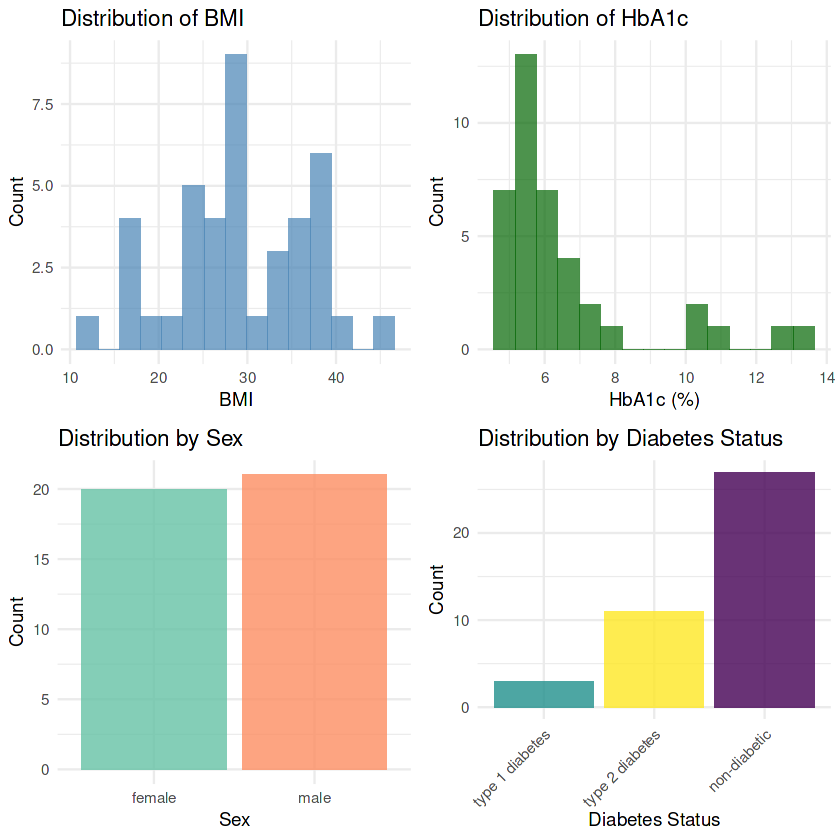

In [9]:
# BMI histogram
p1 <- ggplot(donor_metadata, aes(x = bmi)) +
  geom_histogram(bins = 15, fill = "steelblue", alpha = 0.7) +
  labs(title = "Distribution of BMI", x = "BMI", y = "Count") +
  theme_minimal()

# HbA1c histogram
p2 <- ggplot(donor_metadata, aes(x = hba1c)) +
  geom_histogram(bins = 15, fill = "darkgreen", alpha = 0.7) +
  labs(title = "Distribution of HbA1c", x = "HbA1c (%)", y = "Count") +
  theme_minimal()

# Sex barplot
sex_counts <- table(donor_metadata$sex)
p3 <- ggplot(data.frame(sex = names(sex_counts), count = as.numeric(sex_counts)), 
             aes(x = sex, y = count, fill = sex)) +
  geom_bar(stat = "identity", alpha = 0.8) +
  labs(title = "Distribution by Sex", x = "Sex", y = "Count") +
  scale_fill_brewer(type = "qual", palette = "Set2") +
  theme_minimal() +
  theme(legend.position = "none")

# Diabetes status barplot
diabetes_counts <- table(donor_metadata$diabetes_status_description, useNA = "ifany")
p4 <- ggplot(data.frame(status = names(diabetes_counts), count = as.numeric(diabetes_counts)), 
             aes(x = reorder(status, count), y = count, fill = status)) +
  geom_bar(stat = "identity", alpha = 0.8) +
  labs(title = "Distribution by Diabetes Status", x = "Diabetes Status", y = "Count") +
  scale_fill_viridis_d() +
  theme_minimal() +
  theme(legend.position = "none", axis.text.x = element_text(angle = 45, hjust = 1))

# Combine plots
grid.arrange(p1, p2, p3, p4, ncol = 2)

### BMI vs HbA1c Scatterplot

`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 2 rows containing non-finite outside the scale range (`stat_smooth()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


Correlation between BMI and HbA1c: -0.224 (p-value: 0.17 )


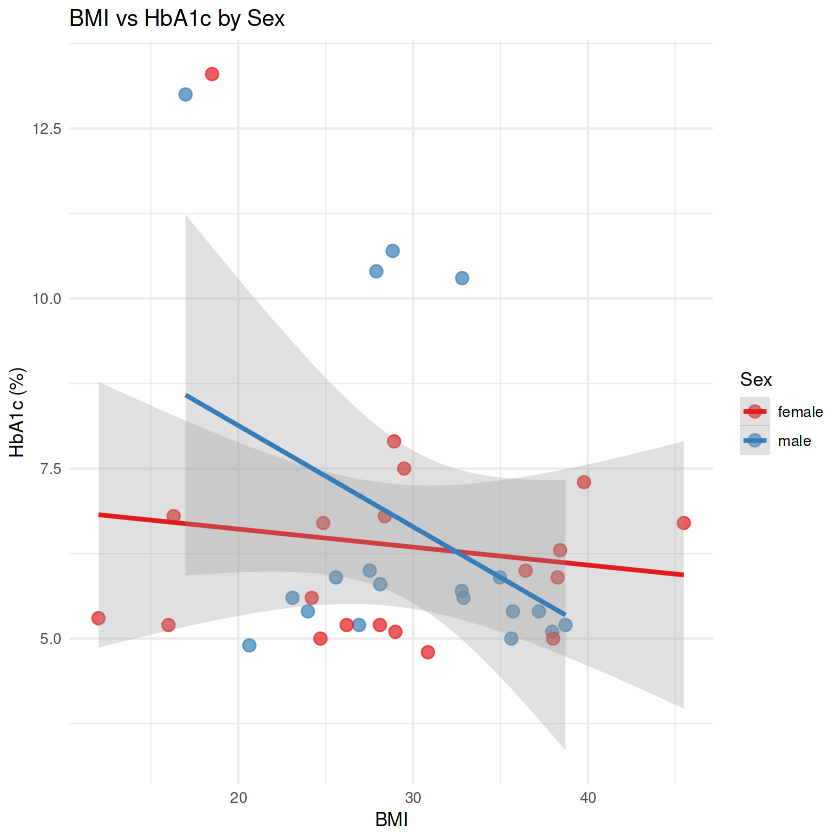

In [10]:
# BMI vs HbA1c scatter plot
p5 <- ggplot(donor_metadata, aes(x = bmi, y = hba1c, color = sex)) +
  geom_point(size = 3, alpha = 0.7) +
  geom_smooth(method = "lm", se = TRUE, alpha = 0.3) +
  labs(title = "BMI vs HbA1c by Sex", 
       x = "BMI", y = "HbA1c (%)", color = "Sex") +
  scale_color_brewer(type = "qual", palette = "Set1") +
  theme_minimal()

print(p5)

# Calculate correlation
cor_result <- cor.test(donor_metadata$bmi, donor_metadata$hba1c, use = "complete.obs")
cat("Correlation between BMI and HbA1c:", round(cor_result$estimate, 3), 
    "(p-value:", round(cor_result$p.value, 4), ")\n")

### Sample Metadata Plots



Table: Sample Size Summary

|metric                | value|
|:---------------------|-----:|
|Total Samples         |    41|
|Total Donors          |    41|
|Avg Samples per Donor |     1|


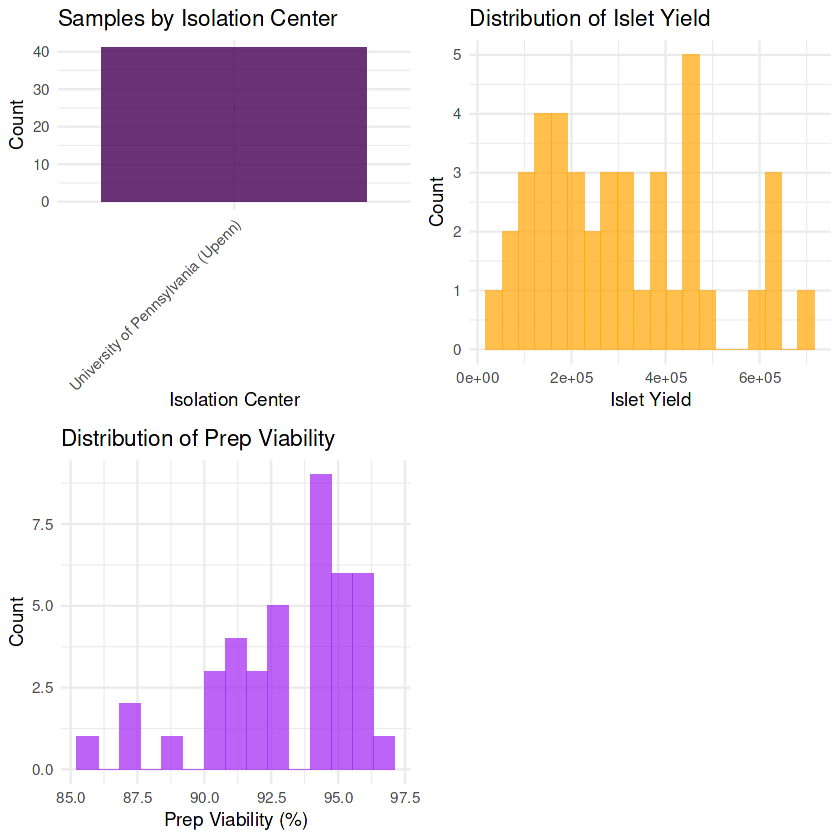

In [11]:
# Isolation center barplot
center_counts <- table(sample_metadata$isolation_center, useNA = "ifany")
p6 <- ggplot(data.frame(center = names(center_counts), count = as.numeric(center_counts)), 
             aes(x = reorder(center, count), y = count, fill = center)) +
  geom_bar(stat = "identity", alpha = 0.8) +
  labs(title = "Samples by Isolation Center", x = "Isolation Center", y = "Count") +
  scale_fill_viridis_d() +
  theme_minimal() +
  theme(legend.position = "none", axis.text.x = element_text(angle = 45, hjust = 1))

# Islet yield histogram
p7 <- ggplot(sample_metadata, aes(x = islet_yield)) +
  geom_histogram(bins = 20, fill = "orange", alpha = 0.7) +
  labs(title = "Distribution of Islet Yield", x = "Islet Yield", y = "Count") +
  theme_minimal()

# Prep viability histogram
p8 <- ggplot(sample_metadata, aes(x = prep_viability)) +
  geom_histogram(bins = 15, fill = "purple", alpha = 0.7) +
  labs(title = "Distribution of Prep Viability", x = "Prep Viability (%)", y = "Count") +
  theme_minimal()

# Sample size distribution
sample_size_summary <- data.frame(
  metric = c("Total Samples", "Total Donors", "Avg Samples per Donor"),
  value = c(nrow(sample_metadata), 
           length(unique(sample_metadata$donor_accession)),
           round(nrow(sample_metadata) / length(unique(sample_metadata$donor_accession)), 2))
)

print(knitr::kable(sample_size_summary, caption = "Sample Size Summary"))

# Combine sample plots
grid.arrange(p6, p7, p8, ncol = 2, nrow = 2)

### READ RDS object and make plots

In [12]:
# Download and load the RDS file with better handling for large files
rds_url <- "https://pankbase-data-v1.s3.us-west-2.amazonaws.com/analysis_resources/single_cell_objects/PanKbase_snatac_v1.rds"
local_file <- "seurat_object.Rds"

cat("Attempting to download large RDS file (~10GB)...\n")
cat("This may take several minutes depending on your internet connection.\n")

# Function to download large files with progress and better timeout handling
download_large_file <- function(url, destfile, timeout = 3600) {
  tryCatch({
    # Set longer timeout for large files (1 hour)
    options(timeout = timeout)
    
    # Try downloading with curl if available (better for large files)
    if (Sys.which("curl") != "") {
      cat("Using curl for download...\n")
      system_command <- sprintf('curl -L -o "%s" "%s"', destfile, url)
      result <- system(system_command)
      
      if (result == 0 && file.exists(destfile)) {
        return(TRUE)
      } else {
        cat("Curl download failed, trying R download.file...\n")
      }
    }
    
    # Fallback to R's download.file with extended timeout
    cat("Using R download.file with extended timeout...\n")
    download.file(url, destfile = destfile, mode = "wb", timeout = timeout)
    
    if (file.exists(destfile)) {
      return(TRUE)
    } else {
      return(FALSE)
    }
    
  }, error = function(e) {
    cat("Download error:", e$message, "\n")
    return(FALSE)
  })
}

# Attempt download
download_success <- download_large_file(rds_url, local_file, timeout = 3600)

if (download_success && file.exists(local_file)) {
  cat("Download completed successfully!\n")
  file_size <- file.info(local_file)$size
  cat("File size:", round(file_size / 1024^3, 2), "GB\n")
  
  # Load the Seurat object
  cat("Loading Seurat object (this may take a few minutes)...\n")
  tryCatch({
    seurat_obj <- readRDS(local_file)
    cat("Seurat object loaded successfully!\n")
    cat("Number of cells:", ncol(seurat_obj), "\n")
    cat("Number of features:", nrow(seurat_obj), "\n")
    print(seurat_obj)
    
  }, error = function(e) {
    cat("Error loading RDS file:", e$message, "\n")
    cat("The file may be corrupted or incomplete.\n")
    seurat_obj <- NULL
  })
  
} else {
  cat("Download failed. The file is very large (~10GB) and may require:\n")
  cat("1. A stable, fast internet connection\n")
  cat("2. Sufficient disk space\n")
  cat("3. Extended time (potentially 30+ minutes)\n\n")
  
  cat("Alternative approaches:\n")
  cat("1. Download manually using a download manager\n")
  cat("2. Use command line: wget or curl\n")
  cat("3. Download in parts if the server supports range requests\n\n")
  
  # Try to get file metadata without downloading
  cat("Attempting to get file information...\n")
  tryCatch({
    response <- HEAD(rds_url)
    if (status_code(response) == 200) {
      headers <- headers(response)
      if ("content-length" %in% names(headers)) {
        size_bytes <- as.numeric(headers$`content-length`)
        size_gb <- round(size_bytes / 1024^3, 2)
        cat("Confirmed file size:", size_gb, "GB\n")
      }
      if ("last-modified" %in% names(headers)) {
        cat("Last modified:", headers$`last-modified`, "\n")
      }
    }
  }, error = function(e) {
    cat("Could not retrieve file metadata\n")
  })
  
  seurat_obj <- NULL
}

Attempting to download large RDS file (~10GB)...
This may take several minutes depending on your internet connection.
Using curl for download...
Download completed successfully!
File size: 23.29 GB
Loading Seurat object (this may take a few minutes)...
Seurat object loaded successfully!


Loading required package: Signac


Attaching package: ‘Signac’


The following object is masked _by_ ‘.GlobalEnv’:

    atac_small




Number of cells: 97837 
Number of features: 481311 
An object of class Seurat 
1303997 features across 97837 samples within 4 assays 
Active assay: ATAC_peaks (481311 features, 481311 variable features)
 2 layers present: counts, data
 3 other assays present: RNA, Final_Peaks, Unified_Peaks
 3 dimensional reductions calculated: lsi, harmony.atac, umap.atac


In [13]:
if (exists("seurat_obj") && !is.null(seurat_obj)) {
  cat("=== SEURAT OBJECT ANALYSIS ===\n")
  
  # Check available reductions
  cat("Available dimensional reductions:\n")
  print(names(seurat_obj@reductions))
  
  # Check metadata columns
  cat("\nMetadata columns:\n")
  print(colnames(seurat_obj@meta.data))
  
  # Display first few rows of metadata
  cat("\nFirst few rows of cell metadata:\n")
  print(head(seurat_obj@meta.data))
  
  # Check if UMAP coordinates exist
  if ("umap" %in% names(seurat_obj@reductions)) {
    cat("\nUMAP coordinates are available!\n")
    umap_coords <- Embeddings(seurat_obj, reduction = "umap")
    cat("UMAP dimensions:", dim(umap_coords), "\n")
  } else {
    cat("\nUMAP coordinates not found. Available reductions:", names(seurat_obj@reductions), "\n")
  }
  
} else {
  cat("Seurat object not available for analysis.\n")
}

=== SEURAT OBJECT ANALYSIS ===
Available dimensional reductions:
[1] "lsi"          "harmony.atac" "umap.atac"   

Metadata columns:
 [1] "orig.ident"              "nCount_ATAC_peaks"      
 [3] "nFeature_ATAC_peaks"     "library"                
 [5] "sex"                     "condition"              
 [7] "ATAC_peaks_snn_res.1.5"  "seurat_clusters"        
 [9] "nCount_RNA"              "nFeature_RNA"           
[11] "nucleosome_signal"       "nucleosome_percentile"  
[13] "TSS.enrichment"          "TSS.percentile"         
[15] "reads_in_peaks"          "reads_in_promoters"     
[17] "tss_used"                "frac_reads_in_peaks"    
[19] "frac_reads_in_promoters" "frac_promoters_used"    
[21] "frac_mito_reads"         "frac_duplicated_reads"  
[23] "high.tss"                "nucleosome_group"       
[25] "sub_25_cluster"          "old.ident"              
[27] "sub_18_cluster"          "sub_20_cluster"         
[29] "old.ident.subcluster"    "AAB"                    
[31] "nCount

Found cluster information in: seurat_clusters 


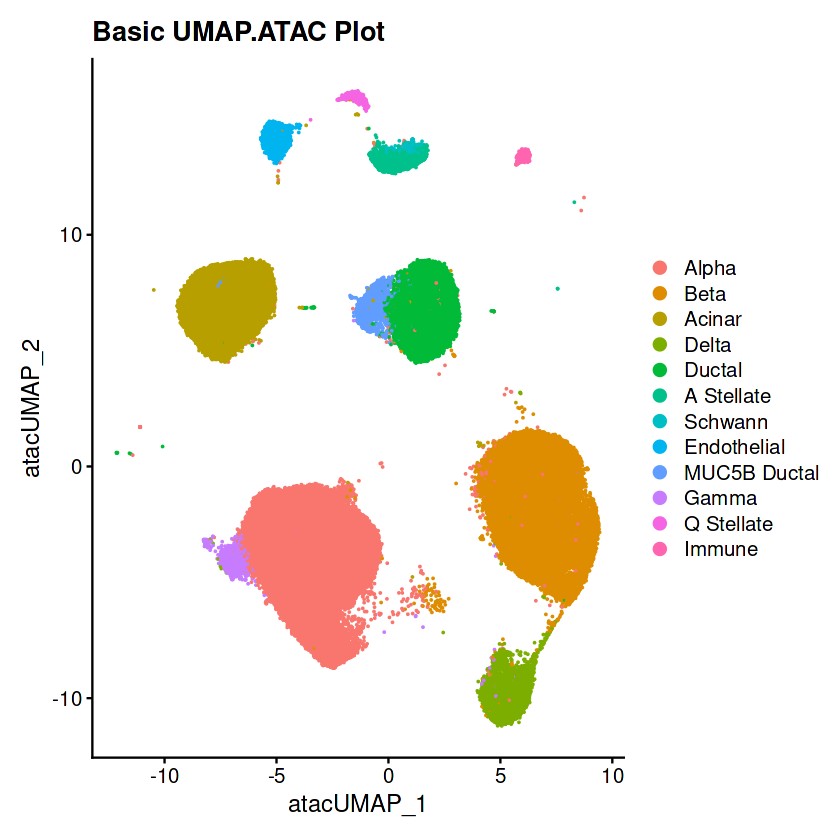

Found cell type information in: Cell.Type 


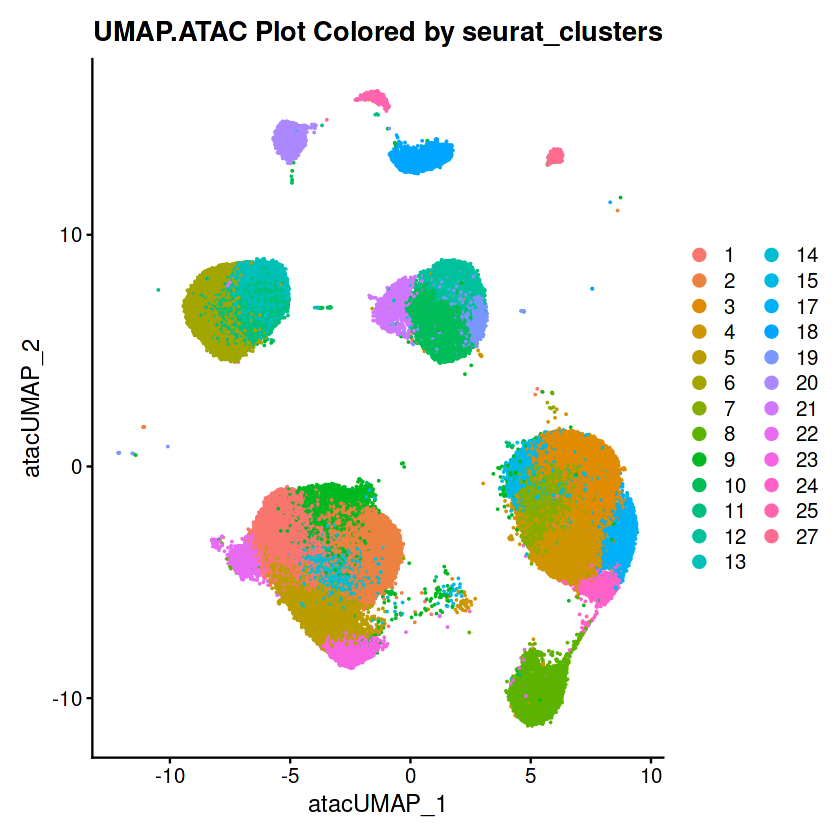

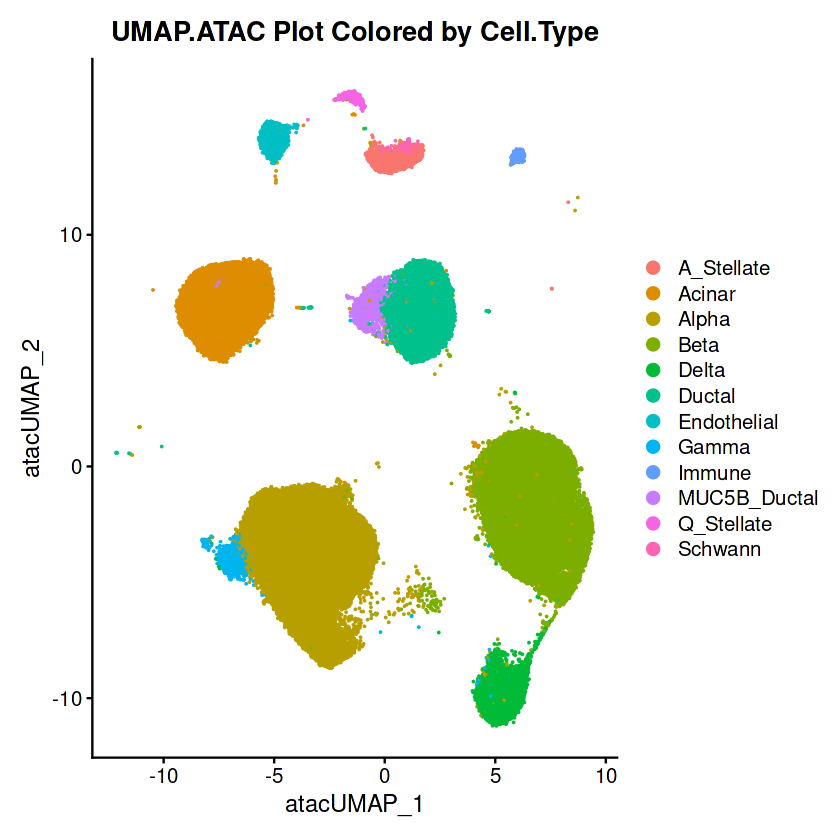

In [19]:
if (exists("seurat_obj") && !is.null(seurat_obj)) {
  
  # Check for UMAP or other reductions
  if ("umap.atac" %in% names(seurat_obj@reductions)) {
    reduction_to_use <- "umap.atac"
  } else if ("tsne" %in% names(seurat_obj@reductions)) {
    reduction_to_use <- "tsne"
    cat("UMAP not available, using t-SNE instead.\n")
  } else if (length(names(seurat_obj@reductions)) > 0) {
    reduction_to_use <- names(seurat_obj@reductions)[1]
    cat("Using first available reduction:", reduction_to_use, "\n")
  } else {
    cat("No dimensional reductions available in the object.\n")
    reduction_to_use <- NULL
  }
  
  if (!is.null(reduction_to_use)) {
    # Basic UMAP/reduction plot
    p_basic <- DimPlot(seurat_obj, reduction = reduction_to_use) +
      ggtitle(paste("Basic", toupper(reduction_to_use), "Plot"))
    print(p_basic)
    
    # Check for clustering information
    cluster_cols <- grep("cluster|seurat_clusters", colnames(seurat_obj@meta.data), 
                        value = TRUE, ignore.case = TRUE)
    
    if (length(cluster_cols) > 0) {
      cat("Found cluster information in:", cluster_cols[1], "\n")
      p_cluster <- DimPlot(seurat_obj, reduction = reduction_to_use, 
                          group.by = cluster_cols[1]) +
        ggtitle(paste(toupper(reduction_to_use), "Plot Colored by", cluster_cols[1]))
      print(p_cluster)
    }
    
    # Check for cell type annotations
    celltype_cols <- grep("cell.type|celltype|annotation", colnames(seurat_obj@meta.data), 
                         value = TRUE, ignore.case = TRUE)
    
    if (length(celltype_cols) > 0) {
      cat("Found cell type information in:", celltype_cols[1], "\n")
      p_celltype <- DimPlot(seurat_obj, reduction = reduction_to_use, 
                           group.by = celltype_cols[1]) +
        ggtitle(paste(toupper(reduction_to_use), "Plot Colored by", celltype_cols[1]))
      print(p_celltype)
    }
  }
  
} else {
  cat("Cannot create UMAP plot - Seurat object not available.\n")
}